In [1]:
import pandas as pd

# Load raw datasets (update paths accordingly)
kyc = pd.read_csv('/Users/mac/Desktop/kyc.csv')
emt = pd.read_csv('/Users/mac/Desktop/emt.csv')
wire = pd.read_csv('/Users/mac/Desktop/wire.csv')
abm = pd.read_csv('/Users/mac/Desktop/abm.csv')
cheque = pd.read_csv('/Users/mac/Desktop/cheque.csv')
card = pd.read_csv('/Users/mac/Desktop/card.csv')
eft = pd.read_csv('/Users/mac/Desktop/eft.csv')

# Tag each with its source
emt['source'] = 'EMT'
wire['source'] = 'Wire'
abm['source'] = 'ABM'
cheque['source'] = 'Cheque'
card['source'] = 'Card'
eft['source'] = 'EFT'

# Concatenate all transactions
all_transactions = pd.concat([emt, wire, abm, cheque, card, eft], ignore_index=True)
all_transactions = pd.merge(all_transactions, kyc, on="customer_id", how="left")

# Convert numeric fields as needed
all_transactions['amount_cad'] = pd.to_numeric(all_transactions['amount_cad'], errors='coerce').fillna(0)


In [2]:
# Aggregate transactions per customer
customer_summary = all_transactions.groupby("customer_id").agg({
    "amount_cad": ["sum", "mean", "count"],
    "source": "nunique"
}).reset_index()

# Rename aggregated columns for clarity
customer_summary.columns = [
    "customer_id",
    "total_amount",
    "avg_amount",
    "transaction_count",
    "transaction_types"
]


In [3]:
# Load the labeled suspicious activity file (update path)
labeled_df = pd.read_csv('/Users/mac/Desktop/suspicious_customers.csv')

# Create the binary label for each customer in customer_summary
customer_summary['is_suspicious'] = customer_summary['customer_id'].isin(labeled_df['customer_id']).astype(int)


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define input features and target
features = customer_summary[['total_amount', 'avg_amount', 'transaction_count', 'transaction_types']].values
X = features.reshape((features.shape[0], 1, features.shape[1]))  # reshape to 3D for LSTM
y = customer_summary['is_suspicious'].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
import tensorflow as tf

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true), axis=-1)

custom_objects = {
    'mse': mse
}

model_bi = tf.keras.models.load_model(
    '/Users/mac/Desktop/model_lstm_bi.h5',
    custom_objects=custom_objects
)
model_lstm = tf.keras.models.load_model(
    '/Users/mac/Desktop/model_lstm.h5',
    custom_objects=custom_objects
)

print("Bidirectional model input shape:", model_bi.input_shape)
print("Standard LSTM model input shape:", model_lstm.input_shape)


/Users/mac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Bidirectional model input shape: (None, 256, 5)
Standard LSTM model input shape: (None, 75, 2)


In [6]:
import numpy as np

def pad_features(X, target_dim):
    """
    Adjusts feature dimension to the target_dim.
    If X has fewer columns, pads with zeros.
    If X has more, truncates.
    """
    n_samples, current_dim = X.shape
    if current_dim < target_dim:
        pad_width = target_dim - current_dim
        padding = np.zeros((n_samples, pad_width))
        return np.concatenate([X, padding], axis=1)
    elif current_dim > target_dim:
        return X[:, :target_dim]
    else:
        return X

def create_sequence(X, seq_length):
    """
    Repeats each sample to create a sequence of fixed length.
    This is a hack for aggregated data to match a sequence model.
    """
    # X is (samples, features); we need (samples, seq_length, features)
    return np.repeat(X[:, np.newaxis, :], seq_length, axis=1)

# Example: Let's assume your aggregated X_test is originally shape (n_samples, current_features)
# For demonstration, suppose:
print("Original X_test shape:", X_test.shape)  # e.g., (n_samples, 4)

# For Bidirectional LSTM (expects 256 timesteps and 5 features):
X_test_bi_features = pad_features(X_test.reshape(X_test.shape[0], -1), 5)  # now (n_samples, 5)
X_test_bi = create_sequence(X_test_bi_features, seq_length=256)             # now (n_samples, 256, 5)

# For Standard LSTM (expects 10 timesteps and 6 features):
X_test_lstm_features = pad_features(X_test.reshape(X_test.shape[0], -1), 6)  # now (n_samples, 6)
X_test_lstm = create_sequence(X_test_lstm_features, seq_length=10)           # now (n_samples, 10, 6)

# Now your X_test_bi and X_test_lstm should match the expected input shapes:
print("Adjusted Bidirectional X_test shape:", X_test_bi.shape)  # (n_samples, 256, 5)
print("Adjusted Standard LSTM X_test shape:", X_test_lstm.shape)  # (n_samples, 10, 6)


Original X_test shape: (3246, 1, 4)
Adjusted Bidirectional X_test shape: (3246, 256, 5)
Adjusted Standard LSTM X_test shape: (3246, 10, 6)


In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def pad_features(X, target_dim):
    """
    Pads or truncates X (shape: (n_samples, current_dim)) so that each sample has exactly target_dim features.
    """
    n_samples, current_dim = X.shape
    if current_dim < target_dim:
        # Pad with zeros
        padding = np.zeros((n_samples, target_dim - current_dim))
        return np.concatenate([X, padding], axis=1)
    elif current_dim > target_dim:
        # Truncate extra features
        return X[:, :target_dim]
    return X

def create_sequence(X, seq_length):
    """
    Repeats each sample to create a sequence of fixed length.
    Converts input of shape (n_samples, features) to (n_samples, seq_length, features).
    """
    return np.repeat(X[:, np.newaxis, :], seq_length, axis=1)

def evaluate_model(model, X_test, y_test, seq_length, target_dim, model_name):
    """
    Prepares the test data, performs predictions, and prints evaluation metrics for a given model.
    
    Parameters:
      model         : Trained model to evaluate.
      X_test        : Aggregated test data (e.g., shape (3246, 1, original_features)).
      y_test        : True labels (expected as a 1D array).
      seq_length    : Desired sequence length for the model input.
      target_dim    : Number of features the model expects per timestep.
      model_name    : String name for printing outputs.
    """
    # Flatten X_test from (n_samples, 1, original_features) to (n_samples, original_features)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Adjust features to have exactly target_dim columns
    X_test_features = pad_features(X_test_flat, target_dim)
    
    # Create a repeated sequence to match the model's expected input shape
    X_test_seq = create_sequence(X_test_features, seq_length)
    print(f"[{model_name}] Adjusted X_test shape: {X_test_seq.shape}")
    print(f"[{model_name}] Model expected input shape: {model.input_shape}")
    
    # Perform predictions
    y_pred_prob_seq = model.predict(X_test_seq)
    print(f"[{model_name}] Raw prediction shape: {y_pred_prob_seq.shape}")
    
    # Extract the prediction from the last timestep.
    # If your output is a single probability (shape (..., 1)), use index 0.
    # If the output has multiple values (e.g., softmax over 2 classes), adjust accordingly.
    if y_pred_prob_seq.shape[-1] == 1:
        y_pred_prob = y_pred_prob_seq[:, -1, 0]
    else:
        # For example, if the positive class probability is at index 1:
        y_pred_prob = y_pred_prob_seq[:, -1, 1]
    print(f"[{model_name}] Extracted prediction shape: {y_pred_prob.shape}")
    
    # Replace NaNs with 0.0 and threshold probabilities at 0.5 to get binary predictions.
    y_pred_prob = np.nan_to_num(y_pred_prob, nan=0.0)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Evaluation metrics
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix ({model_name}):\n", cm)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"ROC-AUC ({model_name}): {roc_auc:.2f}\n")

# ================= STEP A: Prepare Aggregated Test Data =================
# Assume X_test is your aggregated test data with shape (3246, 1, original_features)
print("Original X_test shape:", X_test.shape)

# ================= STEP B: Prepare y_test =================
print("\nOriginal y_test shape:", y_test.shape)
y_test = np.squeeze(y_test)
print("Flattened y_test shape:", y_test.shape)

# ================= STEP C: Evaluate Models =================

# Evaluate the Bidirectional LSTM Model
# Bidirectional LSTM expects input shape: (n_samples, 256, 5)
evaluate_model(
    model=model_bi,
    X_test=X_test,
    y_test=y_test,
    seq_length=256,
    target_dim=5,
    model_name="Bidirectional LSTM"
)

# Evaluate the Standard LSTM Model
# Standard LSTM expects input shape: (None, 75, 2)
evaluate_model(
    model=model_lstm,
    X_test=X_test,
    y_test=y_test,
    seq_length=75,
    target_dim=2,
    model_name="Standard LSTM"
)


Original X_test shape: (3246, 1, 4)

Original y_test shape: (3246,)
Flattened y_test shape: (3246,)
[Bidirectional LSTM] Adjusted X_test shape: (3246, 256, 5)
[Bidirectional LSTM] Model expected input shape: (None, 256, 5)
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step
[Bidirectional LSTM] Raw prediction shape: (3246, 256, 5)
[Bidirectional LSTM] Extracted prediction shape: (3246,)

Classification Report (Bidirectional LSTM):
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      2769
           1       0.00      0.00      0.00       477

    accuracy                           0.83      3246
   macro avg       0.42      0.48      0.45      3246
weighted avg       0.72      0.83      0.77      3246

Confusion Matrix (Bidirectional LSTM):
 [[2681   88]
 [ 477    0]]
ROC-AUC (Bidirectional LSTM): 0.05

[Standard LSTM] Adjusted X_test shape: (3246, 75, 2)
[Standard LSTM] Model expected input shape: (None, 75, 2)
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 2

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ----- Step 1: Adjust Aggregated Test Data -----
# Assume X_test is your aggregated test data with shape (3246, 1, 4)
print("Original X_test shape:", X_test.shape)  # Expected: (3246, 1, 4)

# Flatten X_test from (3246, 1, 4) to (3246, 4)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print("Flattened X_test shape:", X_test_flat.shape)  # Expected: (3246, 4)

def pad_features(X, target_dim):
    """
    Pads each sample in X (shape: (n_samples, current_dim))
    to have target_dim features. If current_dim < target_dim, pads with zeros;
    if greater, truncates.
    """
    n_samples, current_dim = X.shape
    if current_dim < target_dim:
        pad_width = target_dim - current_dim
        padding = np.zeros((n_samples, pad_width))
        X_padded = np.concatenate([X, padding], axis=1)
        print("Padded features shape:", X_padded.shape)  # Should be (n_samples, target_dim)
        return X_padded
    elif current_dim > target_dim:
        X_truncated = X[:, :target_dim]
        print("Truncated features shape:", X_truncated.shape)  # Should be (n_samples, target_dim)
        return X_truncated
    else:
        return X

def create_sequence(X, seq_length):
    """
    Repeats each sample (row) to create a sequence of fixed length.
    Converts (n_samples, features) to (n_samples, seq_length, features)
    """
    return np.repeat(X[:, np.newaxis, :], seq_length, axis=1)

# ----- For Bidirectional LSTM -----
# The model expects shape: (n_samples, 256, 5)
X_test_bi_features = pad_features(X_test_flat, 5)  # Should become (3246, 5)
X_test_bi = create_sequence(X_test_bi_features, seq_length=256)  # Now (3246, 256, 5)
print("Adjusted Bidirectional X_test shape:", X_test_bi.shape)  # Expected: (3246, 256, 5)

# ----- For Standard LSTM -----
# Your Standard LSTM expects input shape: (n_samples, 75, 2)
X_test_lstm_features = pad_features(X_test_flat, 2)  # Now each sample has 2 features
X_test_lstm = create_sequence(X_test_lstm_features, seq_length=75)  # Now (3246, 75, 2)
print("Adjusted Standard LSTM X_test shape:", X_test_lstm.shape)  # Expected: (3246, 75, 2)

# ----- Step 2: Prepare y_test -----
# Ensure y_test is 1D
print("Original y_test shape:", y_test.shape)
y_test = np.squeeze(y_test)
print("Flattened y_test shape:", y_test.shape)  # Expected: (3246,)

# ----- Step 3: Evaluate the Bidirectional LSTM Model -----
# model_bi is expected to accept input of shape (None, 256, 5)
print("Bidirectional model input shape:", model_bi.input_shape)

# Predict on the adjusted Bidirectional data
y_pred_prob_bi_seq = model_bi.predict(X_test_bi)
print("Bidirectional raw prediction shape:", y_pred_prob_bi_seq.shape)  # Should be (3246, 256, 5)
# Extract the last timestep's prediction (assumes probability is at index 0)
y_pred_prob_bi = y_pred_prob_bi_seq[:, -1, 0]
print("Extracted y_pred_prob_bi shape:", y_pred_prob_bi.shape)  # Expected: (3246,)
# Replace any NaNs with 0.0
y_pred_prob_bi = np.nan_to_num(y_pred_prob_bi, nan=0.0)
# Convert probabilities to binary predictions (threshold=0.5)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

print("=== Bidirectional LSTM Evaluation ===")
print(classification_report(y_test, y_pred_bi))
cm_bi = confusion_matrix(y_test, y_pred_bi)
print("Confusion Matrix:\n", cm_bi)
roc_auc_bi = roc_auc_score(y_test, y_pred_prob_bi)
print(f"ROC-AUC: {roc_auc_bi:.2f}")

# ----- Step 4: Evaluate the Standard LSTM Model -----
# model_lstm is expected to accept input of shape (None, 75, 2)
print("Standard LSTM model input shape:", model_lstm.input_shape)

# Predict on the adjusted Standard LSTM data
y_pred_prob_lstm_seq = model_lstm.predict(X_test_lstm)
print("Standard LSTM raw prediction shape:", y_pred_prob_lstm_seq.shape)  # Should be (3246, 75, ?)
# Extract the last timestep's prediction (assumes probability is at index 0)
y_pred_prob_lstm = y_pred_prob_lstm_seq[:, -1, 0]
print("Extracted y_pred_prob_lstm shape:", y_pred_prob_lstm.shape)  # Expected: (3246,)
y_pred_prob_lstm = np.nan_to_num(y_pred_prob_lstm, nan=0.0)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

print("\n=== Standard LSTM Evaluation ===")
print(classification_report(y_test, y_pred_lstm))
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
print("Confusion Matrix:\n", cm_lstm)
roc_auc_lstm = roc_auc_score(y_test, y_pred_prob_lstm)
print(f"ROC-AUC: {roc_auc_lstm:.2f}")

# ----- Step 5: ROI Calculation -----
def compute_roi(conf_matrix, cost_fp=1000, cost_fn=10000):
    """
    Compute ROI given a confusion matrix:
    - conf_matrix: Format [[TN, FP], [FN, TP]]
    - cost_fp: Cost incurred per false positive
    - cost_fn: Loss avoided per true positive (cost per false negative)
    """
    tn, fp, fn, tp = conf_matrix.ravel()
    total_potential_loss = (tp + fn) * cost_fn
    savings = (tp * cost_fn) - (fp * cost_fp)
    roi_percentage = (savings / total_potential_loss) * 100 if total_potential_loss != 0 else 0
    return roi_percentage, savings, total_potential_loss

roi_bi, savings_bi, total_loss_bi = compute_roi(cm_bi)
roi_lstm, savings_lstm, total_loss_lstm = compute_roi(cm_lstm)

print("\n=== ROI Analysis ===")
print(f"Bidirectional LSTM: Savings = ${savings_bi}, Total Potential Loss = ${total_loss_bi}, ROI = {roi_bi:.2f}%")
print(f"Standard LSTM: Savings = ${savings_lstm}, Total Potential Loss = ${total_loss_lstm}, ROI = {roi_lstm:.2f}%")


Original X_test shape: (3246, 1, 4)
Flattened X_test shape: (3246, 4)
Padded features shape: (3246, 5)
Adjusted Bidirectional X_test shape: (3246, 256, 5)
Truncated features shape: (3246, 2)
Adjusted Standard LSTM X_test shape: (3246, 75, 2)
Original y_test shape: (3246,)
Flattened y_test shape: (3246,)
Bidirectional model input shape: (None, 256, 5)
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step
Bidirectional raw prediction shape: (3246, 256, 5)
Extracted y_pred_prob_bi shape: (3246,)
=== Bidirectional LSTM Evaluation ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2769
           1       0.00      0.00      0.00       477

    accuracy                           0.77      3246
   macro avg       0.42      0.45      0.43      3246
weighted avg       0.72      0.77      0.74      3246

Confusion Matrix:
 [[2497  272]
 [ 477    0]]
ROC-AUC: 0.07
Standard LSTM model input shape: (None, 75, 2)
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


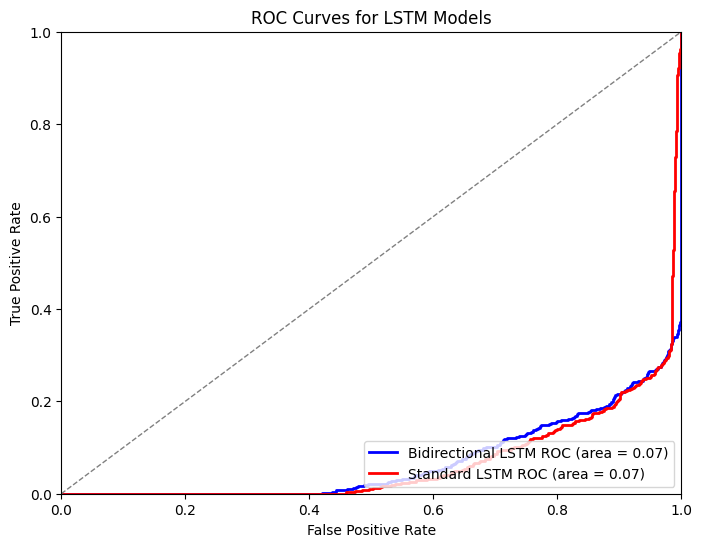

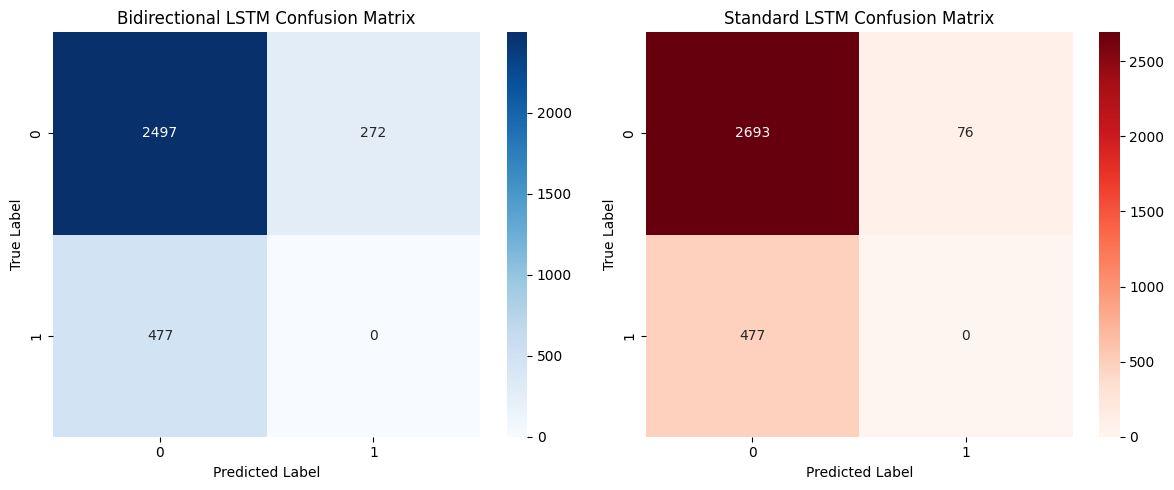

/var/folders/r7/ks7k8hn17dqdqv3766yjwxph0000gn/T/ipykernel_48137/3305321031.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=roi_values, palette='viridis')


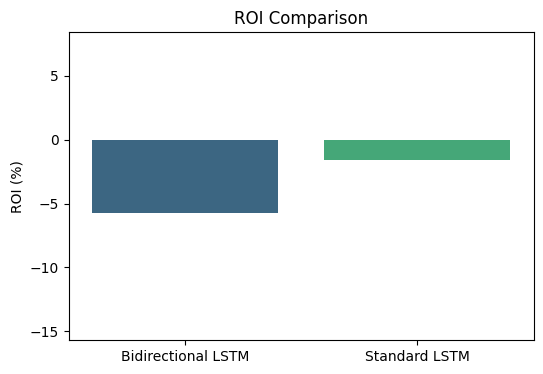

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# -------------------------------
# 1. ROC Curves
# -------------------------------
# Compute ROC curve for Bidirectional LSTM
fpr_bi, tpr_bi, thresholds_bi = roc_curve(y_test, y_pred_prob_bi)
roc_auc_bi_val = auc(fpr_bi, tpr_bi)

# Compute ROC curve for Standard LSTM
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm_val = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bi, tpr_bi, color='blue', lw=2,
         label='Bidirectional LSTM ROC (area = %0.2f)' % roc_auc_bi_val)
plt.plot(fpr_lstm, tpr_lstm, color='red', lw=2,
         label='Standard LSTM ROC (area = %0.2f)' % roc_auc_lstm_val)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for LSTM Models')
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# 2. Confusion Matrix Heatmaps
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_bi, annot=True, fmt="d", cmap='Blues', ax=axes[0])
axes[0].set_title('Bidirectional LSTM Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_lstm, annot=True, fmt="d", cmap='Reds', ax=axes[1])
axes[1].set_title('Standard LSTM Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# -------------------------------
# 3. ROI Comparison Bar Chart
# -------------------------------
# ROI values for each model
roi_values = [roi_bi, roi_lstm]
model_names = ['Bidirectional LSTM', 'Standard LSTM']

plt.figure(figsize=(6, 4))
sns.barplot(x=model_names, y=roi_values, palette='viridis')
plt.title('ROI Comparison')
plt.ylabel('ROI (%)')
plt.ylim(min(roi_values)-10, max(roi_values)+10)
plt.show()
